In [1]:
!pip install -r requirements.txt

In [1]:
import yaml
import numpy as np
import time
import tdmclient.notebook

In [2]:
#import scripts files
from scripts.vision import Vision
from scripts.global_nav import GlobalNav
from scripts.local_nav import LocalNav
from utils import utils

In [3]:
# Load the configuration file
with open('config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)
    
# Simulation configuration
simulation_enabled = config['simulation']

# Controller configuration
angle_tolerance = np.deg2rad(config['controller']['angle_tolerance']) 
distance_tolerance = config['controller']['distance_tolerance'] #mm
scale_rotation_speed = config['controller']['scale_rotation_speed'] 
max_rotation_speed = config['controller']['max_rotation_speed'] 
scale_translation_speed = config['controller']['scale_translation_speed'] 
min_translation_speed = config['controller']['min_translation_speed'] 
max_translation_speed = config['controller']['max_translation_speed'] 

# World configuration
world_width = config['world']['width'] #mm
world_height = config['world']['height'] #mm
obstacle_min_area = config['world']['obstacle_min_area'] #mm²
aruco_size = config['world']['aruco_size'] #mm

# Thymio configuration
thymio_size = config['thymio']['size'] #mm
security_margin = config['thymio']['margin'] #mm

# Webcam configuration
webcam_device_id = config['webcam']['device_id']
webcam_matrix = np.array(config['webcam']['matrix'])
webcam_distortion = np.array(config['webcam']['distortion'])
webcam_resolution = config['webcam']['resolution']
webcam_padding = config['webcam']['padding']
scale_factor = webcam_resolution[1] / world_width


In [4]:
if not simulation_enabled:
    await tdmclient.notebook.start()
    print("Successfully connected to Thymio.")

Successfully connected to Thymio.


In [5]:
@tdmclient.notebook.sync_var
def motor_move(left,right):
    global motor_left_target, motor_right_target
    motor_left_target = left
    motor_right_target = right
    
@tdmclient.notebook.sync_var
def motor_stop():
    global motor_left_target,motor_right_target
    motor_left_target = 0
    motor_right_target = 0
    
@tdmclient.notebook.sync_var
def sensor_data():
    global prox_horizontal
    return prox_horizontal.copy()

print("Thymio functions defined correctly.")

Thymio functions defined correctly.


In [6]:
if not simulation_enabled:
    motor_move(10,10)
    time.sleep(1)
    motor_stop()

In [7]:
vision = Vision(
    device_id=webcam_device_id,
    camera_matrix=webcam_matrix,
    dist_coeffs=webcam_distortion,
    resolution=webcam_resolution,
    padding=webcam_padding,
    scale_factor=scale_factor,
    world_width=world_width,
    world_height=world_height
    
)
global_nav = GlobalNav(
    world_width=world_width,
    world_height=world_height,
    obstacle_min_area=obstacle_min_area,
    thymio_size=thymio_size,
    security_margin=security_margin,
    scale_factor=scale_factor,
    aruco_size=aruco_size
    
)

local_nav = LocalNav(
    angle_threshold=angle_tolerance,
    distance_threshold=distance_tolerance,
    scale_rotation_speed=scale_rotation_speed,
    max_rotation_speed=max_rotation_speed,
    scale_translation_speed=scale_translation_speed,
    min_translation_speed=min_translation_speed,
    max_translation_speed=max_translation_speed
)

Vision Initialized
GlobalNav Initialized
LocalNav Initialized


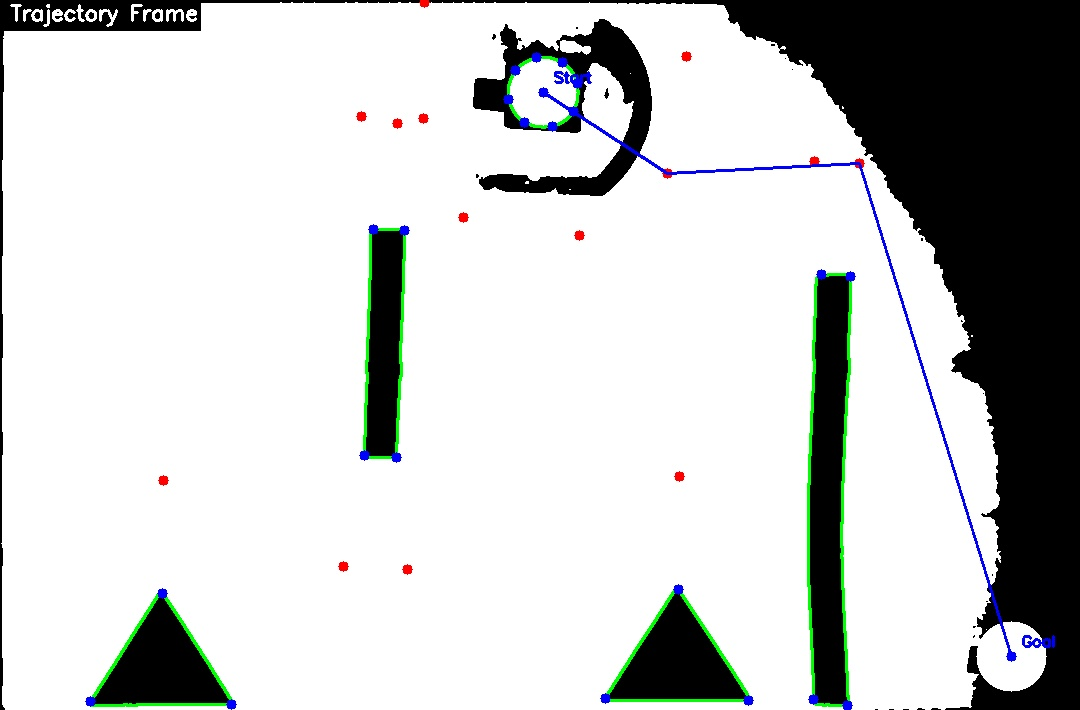

In [8]:
# Global variables
got_trajectory = False
trajectory_frame = None
trajectory_pos_mm = None
obstacles_pos_mm = None
thymio_init_pos_mm = None
thymio_init_orientation_rad = None

try:
    # Try connecting to the webcam
    display(f"Trying to connect to device {webcam_device_id}...")
    if not vision.connect_webcam():
        display("Could not find webcam on any device ID. Please check connection.")
        exit(1)
    else: 
        display(f"Successfully connected to device {webcam_device_id}")
        
    while not got_trajectory:
        original_frame, process_frame, thymio_init_pos_pixels, thymio_init_orientation_rad, goal_pos_pixels= vision.get_frame()
        
        trajectory_frame, trajectory_pos_mm, obstacles_pos_mm, got_trajectory = global_nav.get_trajectory(process_frame, thymio_init_pos_pixels, goal_pos_pixels)

        # Convert thymio pos from pixels to mm
        if np.any(thymio_init_pos_pixels != 0):  # If thymio is detected
            thymio_init_pos_mm = np.array([
                utils.pixels_to_mm(thymio_init_pos_pixels[0], scale_factor), 
                utils.pixels_to_mm(thymio_init_pos_pixels[1], scale_factor)
            ])
            
        utils.display_frames(original_frame, process_frame, None) 
        time.sleep(0.1)
        
except KeyboardInterrupt:
    display("User interrupted the kernel. Closing the webcam...")

finally:
    # Release resources
    vision.cleanup_webcam()
    time.sleep(1)
    utils.display_frames(None, None, trajectory_frame)

In [13]:
obstacles_rounded = {k: np.round(v, 1) for k, v in obstacles_pos_mm.items()}
obstacles_formatted = '\n '.join([f"{k}: {v}" for k, v in obstacles_rounded.items()])
print(f"Obstacles [mm]: \n {obstacles_formatted}")

print(f"Trajectory points [mm]:\n {np.round(trajectory_pos_mm, 1)}")
print(f"Thymio position [mm]:\n {np.round(thymio_init_pos_mm, 1)}")
print(f"Thymio orientation [deg]:\n {np.round(np.rad2deg(thymio_init_orientation_rad), 1)}")
print(f"Goal position [mm]:\n {np.round(trajectory_pos_mm[-1], 1)}")

Obstacles [mm]: 
 obstacle15: [[177.  475.2]
 [ -4.  756.4]
 [329.7 755.1]]
 obstacle24: [[818.3 151.1]
 [807.7 812.6]
 [853.2 814.8]
 [860.8 153.3]]
 obstacle26: [[413.6 107.5]
 [358.1 113.4]
 [376.9 549.7]
 [422.1 547. ]]
Trajectory points [mm]:
 [[377.7  64.5]
 [605.8 107.9]
 [714.3 458.8]]
Thymio position [mm]:
 [377.7  64.5]
Thymio orientation [deg]:
 4.300000190734863
Goal position [mm]:
 [714.3 458.8]


In [14]:
goal_reached = False
background_frame = None
position_history = []  
thymio_current_pos_mm = thymio_init_pos_mm
thymio_current_orientation_rad = thymio_init_orientation_rad

try:
    # Try connecting to the webcam
    display(f"Trying to connect to device {webcam_device_id}...")
    if not vision.connect_webcam():
        display("Could not find webcam on any device ID. Please check connection.")
        exit(1)
    else: 
        display(f"Successfully connected to device {webcam_device_id}")
    
    # If this is the first frame, create a copy of trajectory_frame as background
    if trajectory_frame is not None:
        background_frame = trajectory_frame.copy()
        
    while not goal_reached:
        if not simulation_enabled:
            original_frame, process_frame, thymio_current_pos_pixels, thymio_current_orientation_rad, _= vision.get_frame()
            if np.any(thymio_current_pos_pixels != 0):  # If thymio is detected
                thymio_current_pos_mm = np.array([
                    utils.pixels_to_mm(thymio_current_pos_pixels[0], scale_factor), 
                    utils.pixels_to_mm(thymio_current_pos_pixels[1], scale_factor)
                ])
            else :
                utils.display_frames(original_frame, None, None) 
                time.sleep(0.01)
                continue
        else:
            original_frame, process_frame, _, _, _= vision.get_frame()
            
        # Get next command using updated position and orientation
        command, goal_reached = local_nav.navigate(trajectory_pos_mm, thymio_current_pos_mm, thymio_current_orientation_rad)
        if simulation_enabled:
            # Simulate movement
            new_position, new_orientation = utils.simulate_robot_movement(
                thymio_current_pos_mm, thymio_current_orientation_rad, command
            )
            # Update current position and orientation
            thymio_current_pos_mm = new_position
            thymio_current_orientation_rad = new_orientation
        else:
            if command['action'] == 'move_and_rotate':
                left_speed = command['left_speed']
                right_speed = command['right_speed']
                motor_move(left_speed,right_speed)
            else:
                motor_stop()
        #display(command)
        #Convert new_position from mm to pixels for drawing and store it
        new_position_pixels = np.array([utils.mm_to_pixels(thymio_current_pos_mm[0], scale_factor), utils.mm_to_pixels(thymio_current_pos_mm[1], scale_factor)])
        position_history.append(new_position_pixels)

        # Update trajectory frame with robot
        if background_frame is not None:
            current_frame = background_frame.copy()
            
            # Draw trajectory
            trajectory_frame = utils.draw_trajectory(current_frame, position_history)
            
            # Draw the current robot position
            thymio_size_pixels = np.array([
                utils.mm_to_pixels(thymio_size['width'], scale_factor), 
                utils.mm_to_pixels(thymio_size['length'], scale_factor)
            ])
            trajectory_frame = utils.draw_robot(current_frame, new_position_pixels, thymio_current_orientation_rad, thymio_size_pixels)

        utils.display_frames(None, process_frame, trajectory_frame) 
        time.sleep(0.01)
        
except KeyboardInterrupt:
   display("User interrupted the kernel. Closing the webcam...")
finally:
    # Release resources
    vision.cleanup_webcam()

NameError: name 'motor_move' is not defined

In [20]:
await tdmclient.notebook.stop()